<a href="https://colab.research.google.com/github/noahbean33/PINN_experiments/blob/main/heat_diffusion_ai_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

# Parameters
alpha = 2.3e-5  # Thermal diffusivity in m^2/s
dx = dy = 0.01  # Grid spacing in meters (1 cm)
dt = 1  # Time step in seconds
noise_std = 0.5  # Standard deviation of the Gaussian noise

# Grid dimensions
nx, ny = 10, 10  # Adjusted to a smaller grid for practical visualization

# Initialize temperature grid
T = np.full((nx, ny), 70.0)  # Ambient temperature in Fahrenheit

# Center of the grid
center_x, center_y = nx // 2, ny // 2
T[center_x, center_y] = 200.0  # Initial temperature at the center

# Convert time duration to seconds
time_duration = 5 * 60  # 5 minutes in seconds
n_steps = int(time_duration / dt)

# Function to apply the heat equation with Gaussian noise
def apply_heat_equation(T, alpha, dx, dy, dt, center_x, center_y, noise_std):
    T_new = T.copy()
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            T_new[i, j] = T[i, j] + alpha * dt * (
                (T[i+1, j] - 2*T[i, j] + T[i-1, j]) / dx**2 +
                (T[i, j+1] - 2*T[i, j] + T[i, j-1]) / dy**2
            )
            # Add Gaussian noise
            T_new[i, j] += np.random.normal(0, noise_std)
    # Keep the center continuously heated
    T_new[center_x, center_y] = 200.0
    return T_new

# Simulate heat diffusion with noise
temperature_data = np.zeros((n_steps, nx, ny))

for step in range(n_steps):
    T = apply_heat_equation(T, alpha, dx, dy, dt, center_x, center_y, noise_std)
    temperature_data[step] = T

# Save the data to a numpy file
np.save('/content/data/temperature_data_2_minutes_continuous_heat_noise_small.npy', temperature_data)


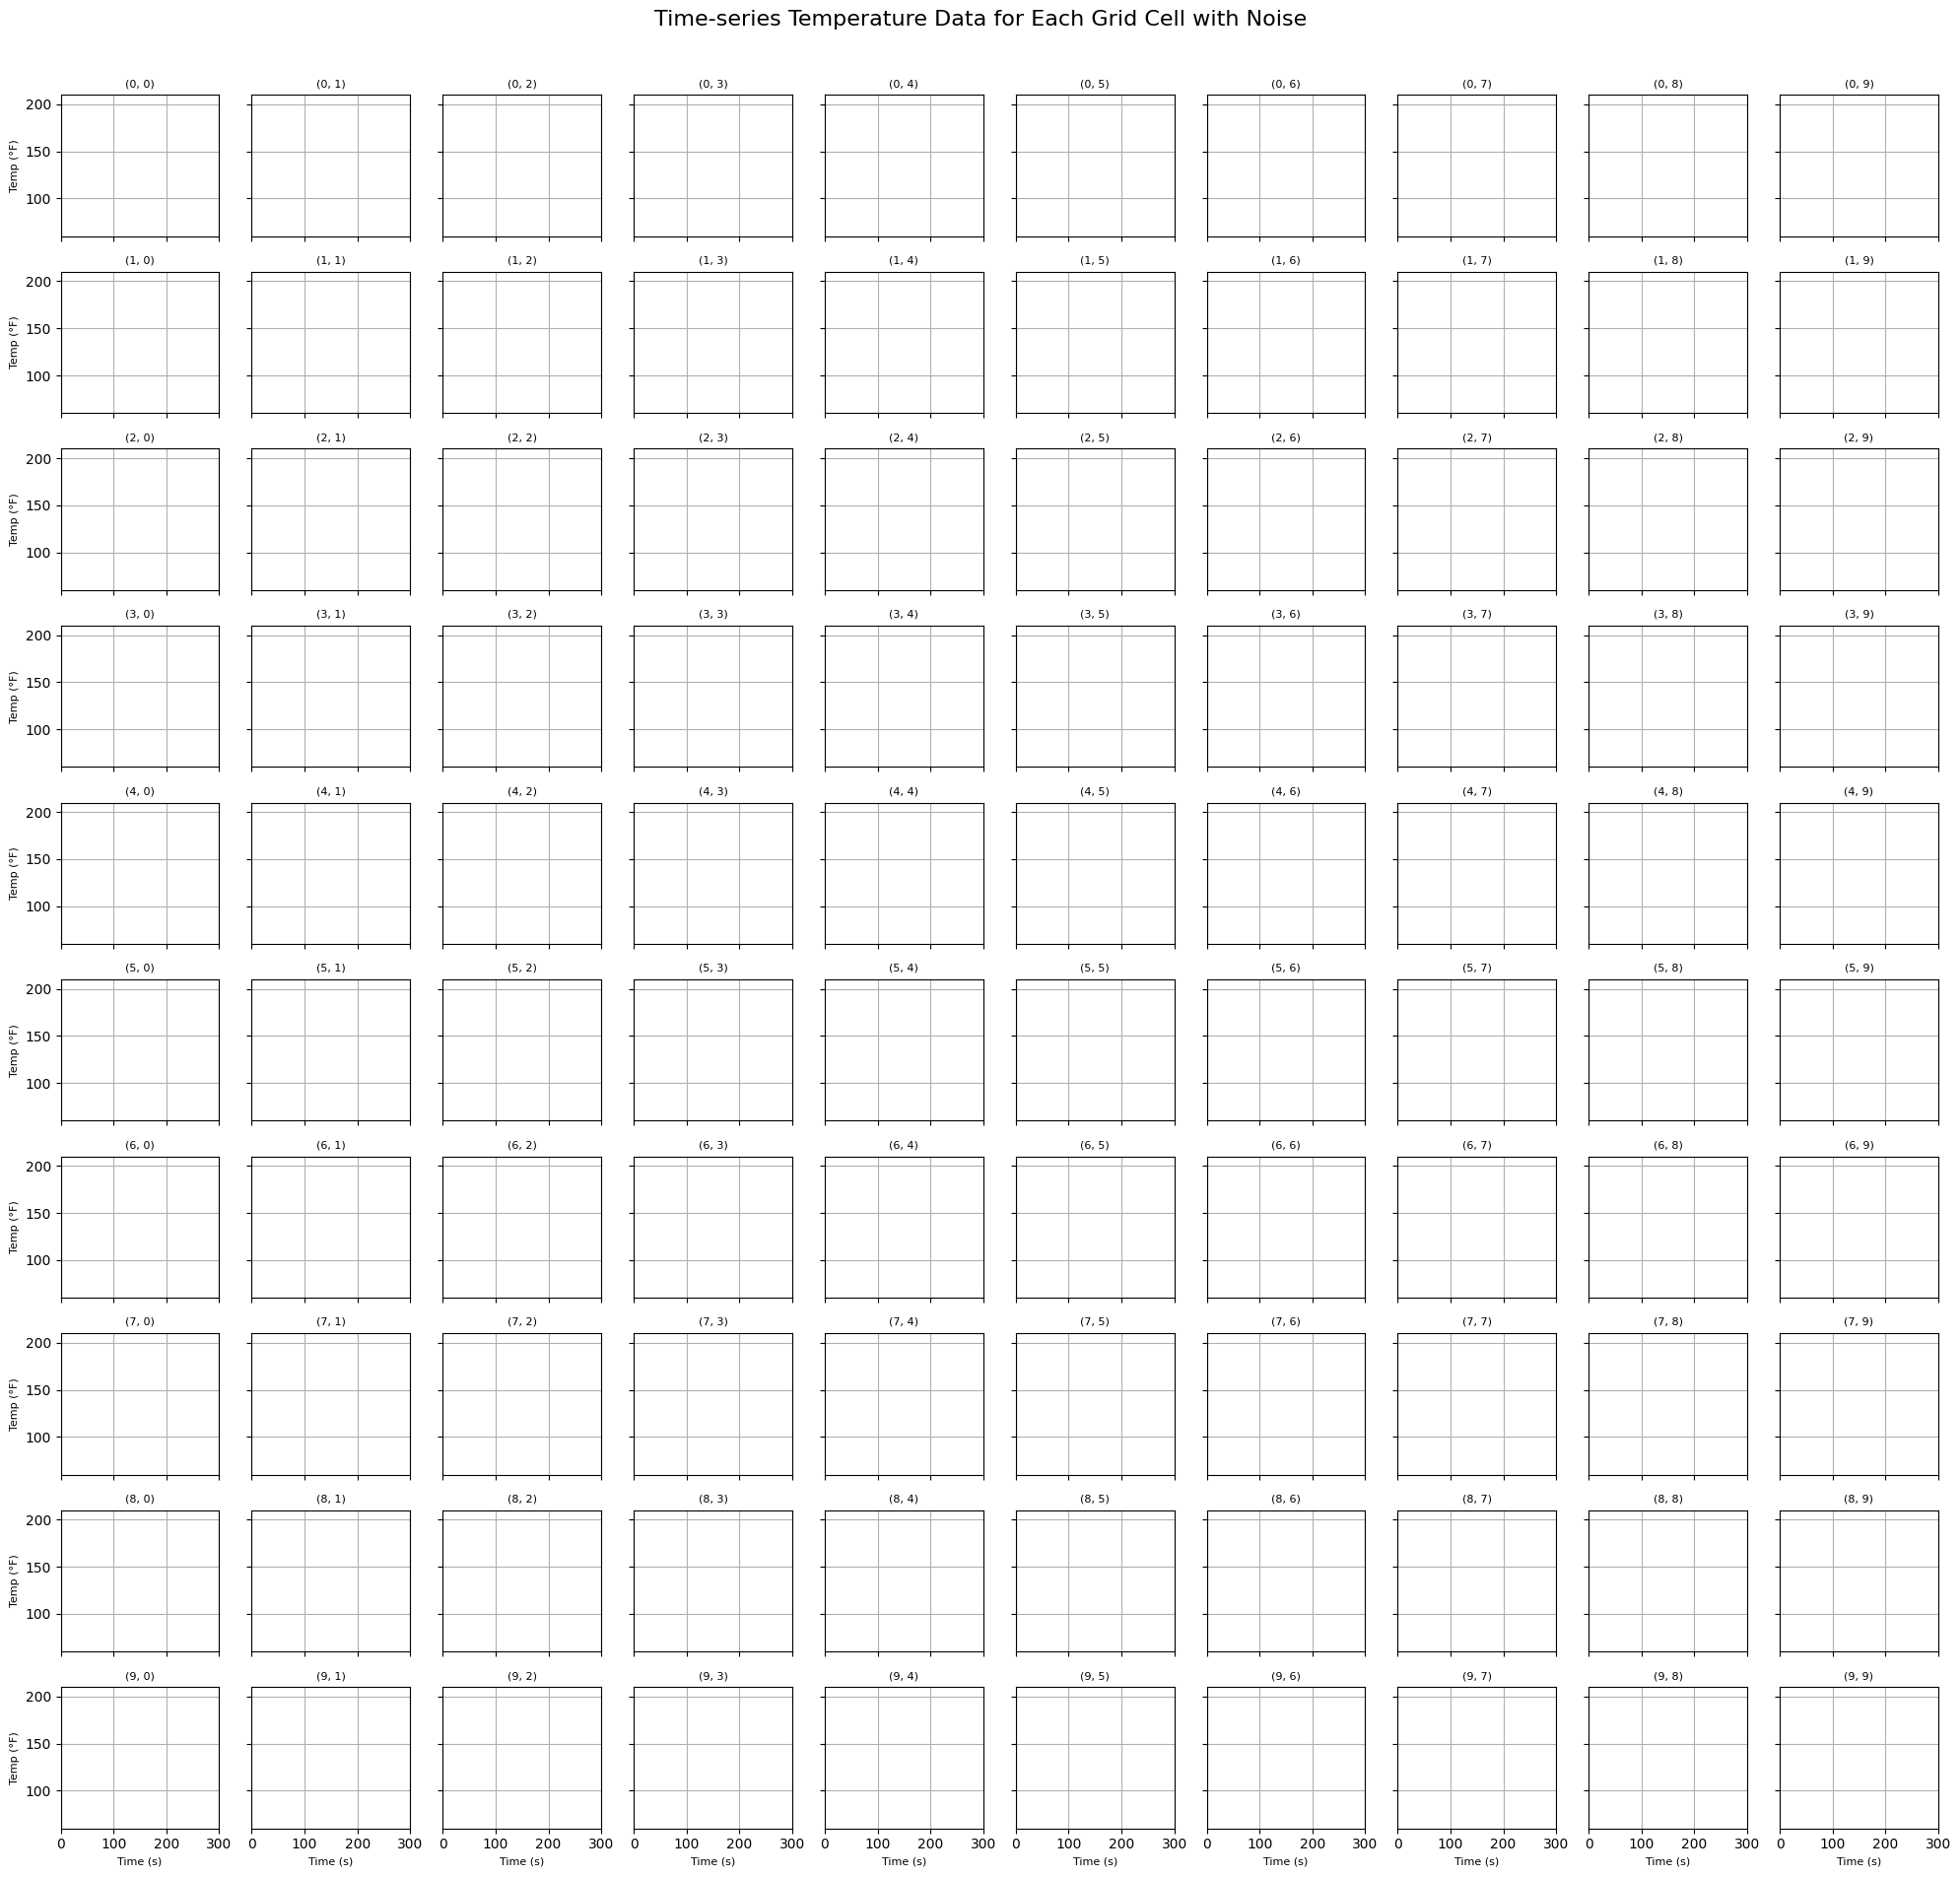

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Load the temperature data
temperature_data = np.load('/content/data/temperature_data_2_minutes_continuous_heat_noise_small.npy')

# Get the grid dimensions and number of time steps
n_steps, nx, ny = temperature_data.shape

# Create subplots for each grid cell
fig, axes = plt.subplots(nx, ny, figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle('Time-series Temperature Data for Each Grid Cell with Noise', fontsize=16)

# Initialize the plots
lines = []
for i in range(nx):
    for j in range(ny):
        line, = axes[i, j].plot([], [], lw=2)
        axes[i, j].set_xlim(0, n_steps)
        axes[i, j].set_ylim(60, 210)  # Adjusted to accommodate noise
        axes[i, j].set_title(f'({i}, {j})', fontsize=8)
        axes[i, j].grid(True)
        if i == nx - 1:
            axes[i, j].set_xlabel('Time (s)', fontsize=8)
        if j == 0:
            axes[i, j].set_ylabel('Temp (°F)', fontsize=8)
        lines.append(line)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Animation update function

def update(frame):
    for k, line in enumerate(lines):
        i, j = divmod(k, ny)
        line.set_data(np.arange(frame+1), temperature_data[:frame+1, i, j])
    return lines
"""
ani = FuncAnimation(fig, update, frames=n_steps, blit=True, repeat=False)

# Save the animation as a GIF
ani.save('/content/data/heat_diffusion_2_minutes_continuous_heat_noise_small.gif', writer=PillowWriter(fps=10))
"""
plt.show()


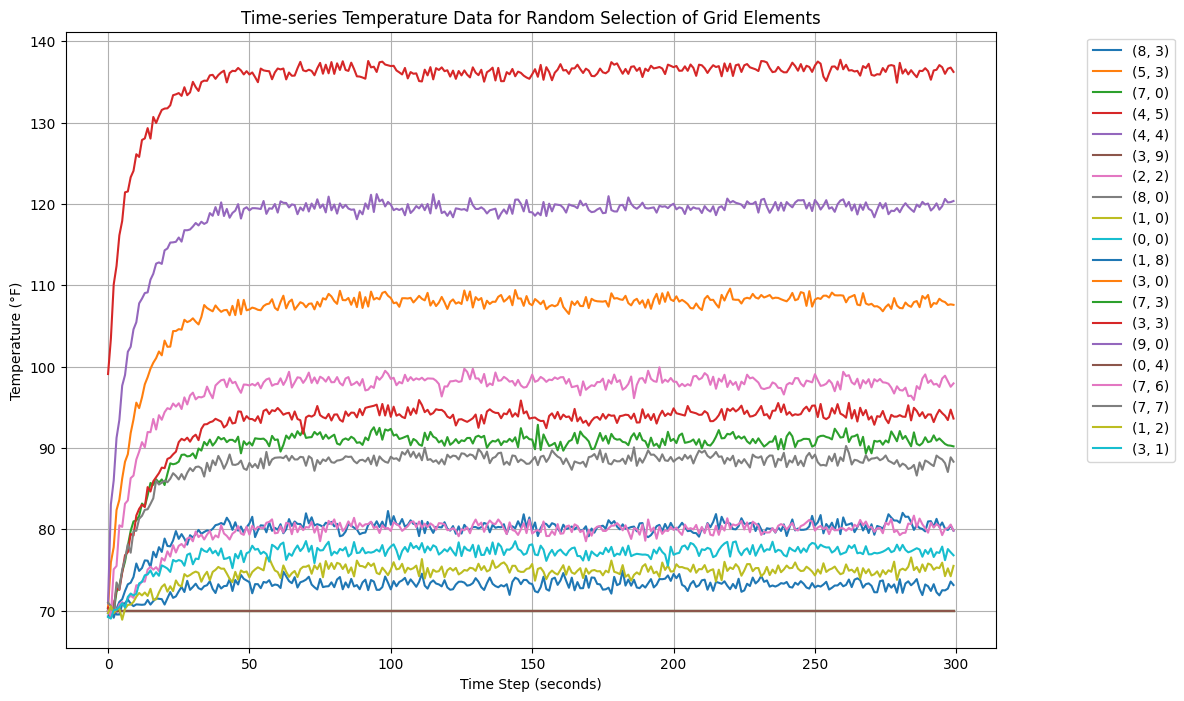

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the temperature data
temperature_data = np.load('/content/data/temperature_data_2_minutes_continuous_heat_noise_small.npy')

# Get the grid dimensions and number of time steps
n_steps, nx, ny = temperature_data.shape

# Randomly select a subset of grid elements
num_elements = 20  # Number of elements to plot
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(nx * ny, num_elements, replace=False)
random_elements = [(idx // ny, idx % ny) for idx in random_indices]

# Create a plot for the random selection of grid elements
plt.figure(figsize=(12, 8))
for i, j in random_elements:
    plt.plot(np.arange(n_steps), temperature_data[:, i, j], label=f'({i}, {j})')

plt.xlabel('Time Step (seconds)')
plt.ylabel('Temperature (°F)')
plt.title('Time-series Temperature Data for Random Selection of Grid Elements')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()


Train data shape: (240, 10, 10)
Test data shape: (60, 10, 10)


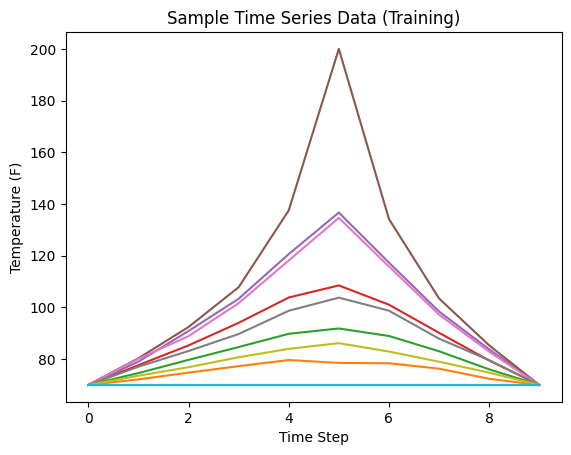

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the data
data = np.load('/content/data/temperature_data_2_minutes_continuous_heat_noise_small.npy')

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Print the shapes of the datasets
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

# Plot a sample of the data to visualize
plt.plot(train_data[0, :, :])
plt.title('Sample Time Series Data (Training)')
plt.xlabel('Time Step')
plt.ylabel('Temperature (F)')
plt.show()


In [ ]:
!pip install  tensorflow keras --upgrade --quiet



In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the neural network architecture
def build_model():
    model = models.Sequential([
        layers.Input(shape=(3,)),  # Input: (x, y, t)
        layers.Dense(20, activation='tanh'),
        layers.Dense(20, activation='tanh'),
        layers.Dense(1)  # Output: T
    ])
    return model

# Custom loss function to enforce the 2D heat diffusion equation
def custom_loss(y_true, y_pred, x, y, t, alpha=0.01):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, t])
        T_pred = model(tf.concat([x, y, t], axis=1))
        T_x = tape.gradient(T_pred, x)
        T_y = tape.gradient(T_pred, y)
    T_xx = tape.gradient(T_x, x)
    T_yy = tape.gradient(T_y, y)
    T_t = tape.gradient(T_pred, t)
    del tape

    heat_equation_loss = tf.reduce_mean((T_t - alpha * (T_xx + T_yy))**2)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse_loss + heat_equation_loss

# Load the data
data = np.load('/content/data/temperature_data_2_minutes_continuous_heat_noise_small.npy')

# Inspect the shape of the original data
print(f'Original data shape: {data.shape}')

# Prepare the data for training
time_steps, grid_x, grid_y = data.shape
x = np.linspace(0, 1, grid_x)
y = np.linspace(0, 1, grid_y)
t = np.linspace(0, 1, time_steps)

# Create meshgrid
X, Y, T = np.meshgrid(x, y, t)

# Flatten the spatial grid but keep time steps separate
X_flat = X.flatten()
Y_flat = Y.flatten()
T_flat = T.flatten()
data_flat = data.flatten()

# Check the shapes
print(f'X_flat shape: {X_flat.shape}')
print(f'Y_flat shape: {Y_flat.shape}')
print(f'T_flat shape: {T_flat.shape}')
print(f'data_flat shape: {data_flat.shape}')

# Ensure the lengths are consistent
num_samples = len(X_flat)
assert len(X_flat) == num_samples
assert len(Y_flat) == num_samples
assert len(T_flat) == num_samples
assert len(data_flat) == num_samples

# Convert data to tensors
x_tensor = tf.convert_to_tensor(X_flat, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(Y_flat, dtype=tf.float32)
t_tensor = tf.convert_to_tensor(T_flat, dtype=tf.float32)
T_tensor = tf.convert_to_tensor(data_flat, dtype=tf.float32)

# Split the data into training and testing sets
train_idx, test_idx = train_test_split(np.arange(num_samples), test_size=0.2, random_state=42)
train_idx = tf.convert_to_tensor(train_idx, dtype=tf.int32)
test_idx = tf.convert_to_tensor(test_idx, dtype=tf.int32)

x_train, x_test = tf.gather(x_tensor, train_idx), tf.gather(x_tensor, test_idx)
y_train, y_test = tf.gather(y_tensor, train_idx), tf.gather(y_tensor, test_idx)
t_train, t_test = tf.gather(t_tensor, train_idx), tf.gather(t_tensor, test_idx)
T_train, T_test = tf.gather(T_tensor, train_idx), tf.gather(T_tensor, test_idx)

# Build and compile the model
model = build_model()
model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, x_train, y_train, t_train))

# Train the model
history = model.fit(tf.stack([x_train, y_train, t_train], axis=1), T_train, epochs=100, batch_size=64, validation_split=0.2)

# Evaluate the model on the testing data
test_loss = model.evaluate(tf.stack([x_test, y_test, t_test], axis=1), T_test)
print(f'Test loss: {test_loss}')

# Visualize the results
T_pred = model.predict(tf.stack([x_test, y_test, t_test], axis=1)).reshape(time_steps, grid_x, grid_y)
plt.plot(T_pred[:, 0, 0])
plt.title('Smoothed Time Series Data (Prediction)')
plt.xlabel('Time Step')
plt.ylabel('Temperature (F)')
plt.show()


Original data shape: (300, 10, 10)
X_flat shape: (30000,)
Y_flat shape: (30000,)
T_flat shape: (30000,)
data_flat shape: (30000,)
Epoch 1/100


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-11-aa1f673f1042>", line 85, in None  *
        lambda y_true, y_pred: custom_loss(y_true, y_pred, x_train, y_train, t_train)
    File "<ipython-input-7-c0b93bec42d2>", line 21, in custom_loss  *
        T_pred = model(tf.concat([x, y, t], axis=1))

    ValueError: Shape must be at least rank 2 but is rank 1 for '{{node lambda/concat}} = ConcatV2[N=3, T=DT_FLOAT, Tidx=DT_INT32](lambda/concat/values_0, lambda/concat/values_1, lambda/concat/values_2, lambda/concat/axis)' with input shapes: [24000], [24000], [24000], [] and with computed input tensors: input[3] = <1>.
